# Tunning Random forest's hyperparameters

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import sys
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy

import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb
from lightgbm import LGBMClassifier
import re

from sklearn.ensemble import GradientBoostingClassifier


warnings.simplefilter('ignore', pd.errors.DtypeWarning)
sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

from TimeSeriesAnalysis.utils.plots_functions_utils import *
from TimeSeriesAnalysis.utils.data_load_save import *
import TimeSeriesAnalysis.utils.data_load_save as data_load_save
import TimeSeriesAnalysis.consts as consts
import TimeSeriesAnalysis.params as params
from TimeSeriesAnalysis.auc_over_time_diff_prob import *
from TimeSeriesAnalysis.build_models_on_transformed_tracks import get_to_run, prep_data

/home/shakarch/.conda/envs/tf-env-new/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/shakarch/.conda/envs/tf-env-new/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/shakarch/.conda/envs/tf-env-new/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
def load_data_(modality, con_train_n, diff_train_n, con_test_n, diff_test_n, load_raw_test_data=False):
    model_path = consts.intensity_model_path if modality == "actin_intensity" else consts.motility_model_path
    _, X_train, X_test, y_train, y_test = data_load_save.load_data(model_path % (1,5), load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
    X_train = X_train.drop(columns=["Spot track ID"])
    X_test = X_test.drop(columns=["Spot track ID"])

    y_train = y_train["target"]
    y_test = y_test["target"]
    
    con_df_test, diff_df_test = None, None
    if load_raw_test_data:
        diff_df_train, con_df_train, con_df_test, diff_df_test = get_to_run(path=consts.storage_path, modality=modality, local_density=False,
                                                           con_train_num=con_train_n, diff_train_num=diff_train_n,
                                                           con_test_num=con_test_n, diff_test_num=diff_test_n,
                                                            feature_type="_", specific_feature_type="_", win_size=params.window_size)
        
    return (X_train, y_train, X_test, y_test), (con_df_test, diff_df_test)

In [21]:
# Number of trees in random forest
n_estimators = [100, 200, 300, 400, 500] # [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 40, num = 10)] + [None]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# Create the random grid
grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
                'class_weight': ['balanced', None]}
print(grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 8, 12, 16, 20, 24, 28, 32, 36, 40, None], 'min_samples_leaf': [1, 2], 'class_weight': ['balanced', None]}


In [7]:
from sklearn.model_selection import train_test_split
path = consts.storage_path + "15-12-2022-motility local dens-False, s1, s5 train [130, 160] diff window/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
_, X_train, X_test, y_train, y_test = load_data(path, load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)

In [23]:
y_train["target"].value_counts(), y_test["target"].value_counts()

(False    468
 True     268
 Name: target, dtype: int64,
 True     577
 False    180
 Name: target, dtype: int64)

In [27]:
def rand_search(random_grid, X_train, y_train):
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 600, cv = 2, verbose=0, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    
    return rf_random

def grid_search(grid, X_train, y_train):
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5, verbose=0, n_jobs=-1, scoring='neg_brier_score')
    # Fit the random search model
    rf_grid.fit(X_train, y_train)
    print(rf_grid.best_params_)
    
    return rf_grid

def evaluate_clf(model, test_features, test_labels):
    predictions = model.predict(test_features)
    probs = model.predict_proba(test_features)[:, 1]
    correct_predictions = np.sum(predictions == test_labels)
    accuracy = correct_predictions / len(test_labels)
    
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    auc_score = metrics.auc(fpr, tpr)
    brier = metrics.brier_score_loss(test_labels, probs)  
    return auc_score, brier

In [25]:
con_train_n = 1
diff_train_n = 5
con_test_n = 2
diff_test_n = 3

def get_best_estimators(modality):
    print(f"\n\n========{modality}========\n")
    # load dataset
    (X_train, y_train, X_test, y_test), (_, _) = load_data_(modality, con_train_n, diff_train_n, con_test_n, diff_test_n)

    print(f"\ntrain: {con_train_n}, {diff_train_n}")
    rf_grid = grid_search(grid, X_train, y_train)
    best_estimator = rf_grid.best_estimator_
    auc, brier = evaluate_clf(best_estimator, X_test, y_test.astype(int))
    print(auc)
    
    print(f"\ntrain: {con_test_n}, {diff_test_n}")
    # switch train & test
    rf_grid_switch = grid_search(grid, X_test, y_test)
    best_grid_switch = rf_grid_switch.best_estimator_
    auc_switch, brier_switch = evaluate_clf(best_grid_switch, X_train, y_train.astype(int))
    print(auc_switch)
    
    avg_auc = np.mean([auc, auc_switch])
    std_auc = np.std([auc, auc_switch])
    print("\n\nauc: {:0.3f}%. +- {:0.3f}%.".format(avg_auc, std_auc))
    
    avg_brier = np.mean([brier, brier_switch])
    std_brier = np.std([brier, brier_switch])
    print("\n\nbrier: {:0.3f}%. +- {:0.3f}%.".format(avg_brier, std_brier))
    
    return best_estimator, best_grid_switch

best_estimator_mot, best_estimator_switch_mot = get_best_estimators("motility")
best_estimator_int, best_estimator_switch_int = get_best_estimators("actin_intensity")



========motility========


train: 1, 5
{'class_weight': None, 'max_depth': 40, 'min_samples_leaf': 1, 'n_estimators': 200}
0.8068650105911805

train: 2, 3
{'class_weight': 'balanced', 'max_depth': 12, 'min_samples_leaf': 1, 'n_estimators': 100}
0.8007717821150657


auc: 0.804%. +- 0.003%.


brier: 0.170%. +- 0.008%.


========actin_intensity========


train: 1, 5
{'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
0.7965241671480839

train: 2, 3
{'class_weight': 'balanced', 'max_depth': 36, 'min_samples_leaf': 2, 'n_estimators': 100}
0.7247748187168731


auc: 0.761%. +- 0.036%.


brier: 0.167%. +- 0.030%.


# classifiers comparison

In [9]:
con_train_n = 1
diff_train_n = 5
con_test_n = 2
diff_test_n = 3
modality="motility"

In [21]:
from tsfresh import select_features
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

# prepare configuration for cross validation test harness
# prepare models
models = []
models.append(('RF', RandomForestClassifier))
models.append(('GB', GradientBoostingClassifier))
models.append(('LR', LogisticRegression))
models.append(('KNN', KNeighborsClassifier))
models.append(('SVM', SVC))


def clean_cols_drop_duplicates(df):
    df= df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_ ]+', '', x))
    df = df.loc[:,~df.columns.duplicated()]

    return df

def compare_algorithms(X_train, y_train, X_test, y_test, con_df_test, diff_df_test, modality):
    
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'roc_auc'
    for name, model_class in models:
        if name=="SVM":
            model = model_class(probability=True)
        else:
            model = model_class()
        model.fit(X_train, y_train)
        auc_score, _ = evaluate_clf(model, X_test, y_test)
        
        if name=="SVM":
            model_flip = model_class(probability=True)
        else:
            model_flip = model_class()
        model_flip.fit(X_test, y_test)
        auc_score_flip, _ = evaluate_clf(model_flip, X_train, y_train)
        
        results.append([auc_score, auc_score_flip])
        names.append(name)
        
        msg = "%s:test scores = %.3f +- (%.3f)" % (name, np.mean([auc_score,auc_score_flip]), np.std([auc_score,auc_score_flip])) + f"aucs: {round(auc_score,4)} original, {round(auc_score_flip,4)} flipped"
        print(msg)
    
#     boxplot algorithm comparison - cross_validation
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.savefig(consts.storage_path + f"eps_figs/algorithm_comparison_{modality}.eps", format="eps")
    plt.show()

RF:test scores = 0.800 +- (0.129)aucs: 0.9297 original, 0.671 flipped
GB:test scores = 0.750 +- (0.250)aucs: 1.0 original, 0.5 flipped
LR:test scores = 0.811 +- (0.189)aucs: 1.0 original, 0.622 flipped
KNN:test scores = 0.750 +- (0.250)aucs: 1.0 original, 0.5 flipped
SVM:test scores = 0.750 +- (0.250)aucs: 1.0 original, 0.5 flipped


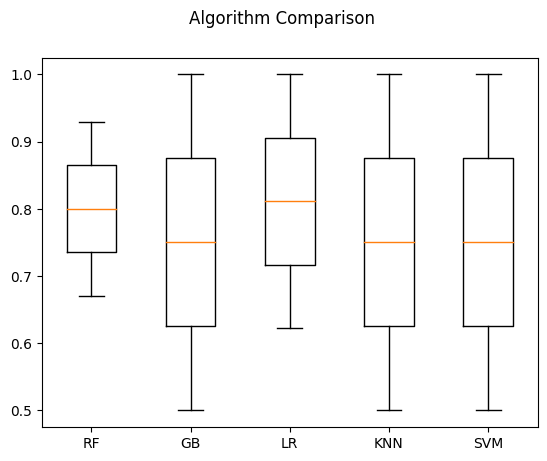

RF:test scores = 0.818 +- (0.117)aucs: 0.9349 original, 0.7005 flipped
GB:test scores = 0.750 +- (0.250)aucs: 1.0 original, 0.5 flipped
LR:test scores = 0.811 +- (0.189)aucs: 1.0 original, 0.622 flipped
KNN:test scores = 0.750 +- (0.250)aucs: 1.0 original, 0.5 flipped
SVM:test scores = 0.750 +- (0.250)aucs: 1.0 original, 0.5 flipped


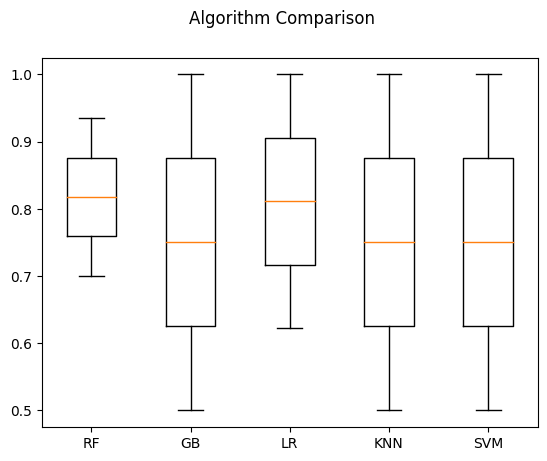

In [28]:
seed = 60 
np.random.seed(seed)
compare_algorithms(X_train, y_train["target"].astype(int) , X_test, y_test["target"].astype(int), con_df_test, diff_df_test, "motility")

path = consts.storage_path + "15-12-2022-actin_intensity local dens-False, s1, s5 train [130, 160] diff window win size 16/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
_, X_train, X_test, y_train, y_test = load_data(path, load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
compare_algorithms(X_train, y_train["target"].astype(int), X_test, y_test["target"].astype(int), con_df_test, diff_df_test, "intensity")

In [9]:
from sklearn.model_selection import train_test_split

con_train_n = 1
diff_train_n = 5
con_test_n = 2
diff_test_n = 3
modality="motility"

path = consts.storage_path + "15-12-2022-motility local dens-False, s1, s5 train [130, 160] diff window/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
(X_train, y_train, X_test, y_test), (con_df_test, diff_df_test) = load_data_(modality, con_train_n, diff_train_n, con_test_n, diff_test_n, load_raw_test_data=True)


read data from video number 5
diff train len (47819, 1580)
read data from video number 1
con_df_train len (16636, 1580)
read data from video number 2
read data from video number 3


RF:test scores = 0.832 +- (0.110)
GB:test scores = 0.750 +- (0.250)
CART:test scores = 0.750 +- (0.250)
LR:test scores = 0.824 +- (0.130)
NB:test scores = 0.499 +- (0.001)
KNN:test scores = 0.750 +- (0.250)
SGD:test scores = 0.820 +- (0.108)
SVM:test scores = 0.750 +- (0.250)


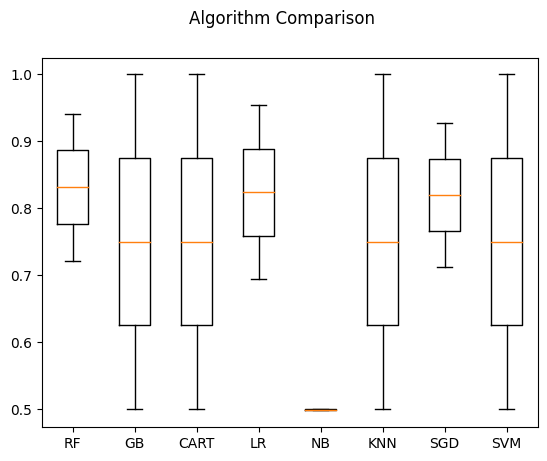

RF:test scores = 0.818 +- (0.115)
GB:test scores = 0.750 +- (0.250)
CART:test scores = 0.750 +- (0.250)
LR:test scores = 0.811 +- (0.189)
NB:test scores = 0.500 +- (0.000)
KNN:test scores = 0.750 +- (0.250)
SGD:test scores = 0.533 +- (0.002)
SVM:test scores = 0.750 +- (0.250)


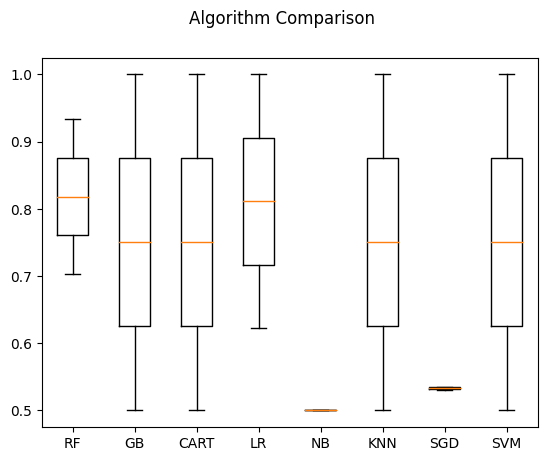

In [202]:
from sklearn.model_selection import train_test_split
path = consts.storage_path + "15-12-2022-motility local dens-False, s1, s5 train [130, 160] diff window/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
_, X_train, X_test, y_train, y_test = load_data(path, load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)

seed = 60 
np.random.seed(seed)
compare_algorithms(X_train, y_train , X_test, y_test, con_df_test, diff_df_test, "motility")

path = consts.storage_path + "15-12-2022-actin_intensity local dens-False, s1, s5 train [130, 160] diff window win size 16/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
_, X_train, X_test, y_train, y_test = load_data(path, load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
compare_algorithms(X_train, y_train, X_test, y_test, con_df_test, diff_df_test, "intensity")

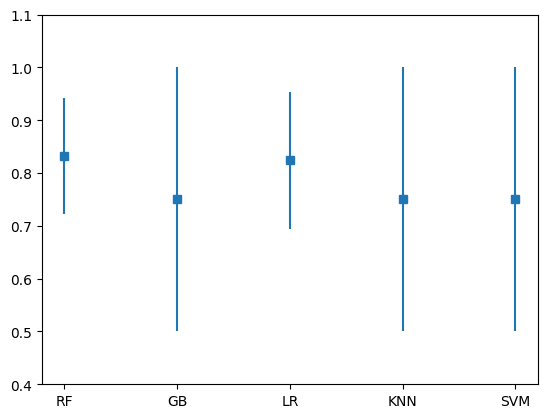

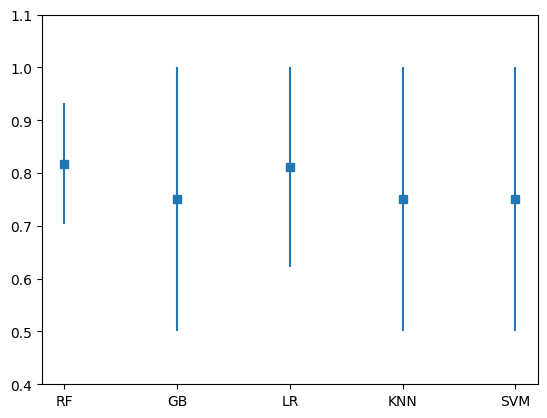

In [68]:
# motility resluts
means = np.array([0.832, 0.750, 0.824, 0.750, 0.750])
std = np.array([0.110, 0.250, 0.130, 0.250, 0.250])

y= ["RF", "GB", "LR", "KNN", "SVM"]
plt.errorbar(y, means, std, linestyle='None', marker='s')
plt.ylim(0.4,1.1)
plt.savefig(consts.storage_path + f"eps_figs/algorithm_comparison_motility errorbar.eps", format="eps")
plt.show()



# actin resluts
means = np.array([0.818, 0.750, 0.811, 0.750, 0.750])
std = np.array([0.115, 0.250, 0.189, 0.250, 0.250])
y= ["RF", "GB", "LR", "KNN", "SVM"]
plt.errorbar(y, means, std, linestyle='None', marker='s')
plt.ylim(0.4,1.1)
plt.savefig(consts.storage_path + f"eps_figs/algorithm_comparison_intensity errorbar.eps", format="eps")
plt.show()

actin [0.78, 0.77, 0.76, 0.59, 0.54]
motility [0.8, 0.8, 0.64, 0.59, 0.59]


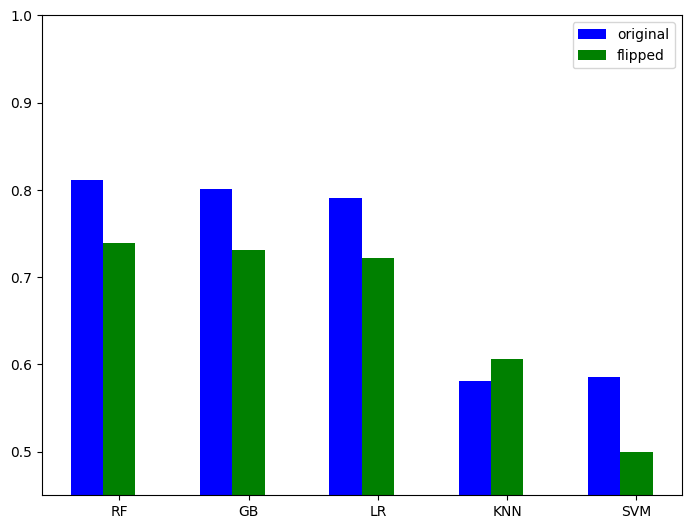

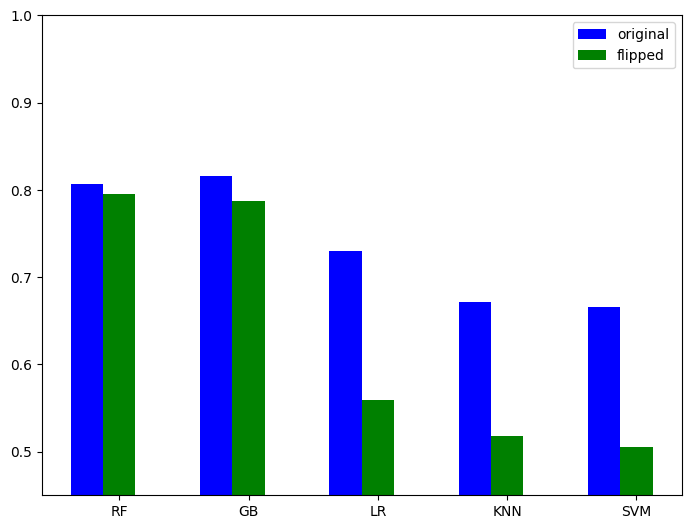

In [73]:
# actin intensity
names = ["RF", "GB", "LR", "KNN", "SVM"]
aucs_original = [0.8114577315617176, 0.8008809936452917, 0.7904823801270942, 0.5811910263816675, 0.5858463316002311]
aucs_flipped = [0.7390986245244366, 0.7311603745976003, 0.721543426657562, 0.605701069814327, 0.5]
mean_aucs = [round(val, 2) for val in np.mean([aucs_original, aucs_flipped], axis=0)]
print("actin", mean_aucs)

X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, aucs_original, color = 'b', width = 0.25, tick_label=names, label="original")
ax.bar(X + 0.25, aucs_flipped, color = 'g', width = 0.25, tick_label=names, label="flipped")
plt.ylim((0.45, 1))
plt.savefig(consts.storage_path + f"eps_figs/algorithm_comparison_intensity barplot.eps", format="eps")
plt.legend()

# motility
names = ["RF", "GB", "LR", "KNN", "SVM"]
aucs_original = [0.8068650105911805, 0.8162189485846331, 0.7303822453302523, 0.6715386096668592, 0.6657471596379743]##[0.8033988060851146, 0.8117080685538225, 0.7258713652994415, 0.6715386096668592, 0.6657471596379743]]
aucs_flipped = [0.7949036866947314, 0.7866277586426841, 0.5595898711570353, 0.5179550963133053, 0.5053418803418803]##[0.7900880214313051, 0.7898328868478122, 0.5595898711570353, 0.5179550963133053, 0.5053418803418803]]
print("motility", [round(val, 2) for val in  np.mean([aucs_original, aucs_flipped], axis=0)])
X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, aucs_original, color = 'b', width = 0.25, tick_label=names, label="original")
ax.bar(X + 0.25, aucs_flipped, color = 'g', width = 0.25, tick_label=names, label="flipped")
plt.ylim((0.45, 1))
plt.savefig(consts.storage_path + f"eps_figs/algorithm_comparison_motility barplot.eps", format="eps")
plt.legend()
